In [1]:
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import itertools
import pandas as pd
from pandas import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
from fbprophet import Prophet

In [2]:
data_tr = pd.read_csv("StoresData/Input.csv", parse_dates= True, low_memory= False, index_col= 'Date')

In [3]:
data_st = pd.read_csv("StoresData/Stores_data.csv", low_memory= False)

In [4]:
data_tr.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [5]:
print("Total dataset", data_tr.shape)
data_tr.head()

Total dataset (1017209, 8)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [6]:
data_tr['Year'] = data_tr.index.year
data_tr['Month'] = data_tr.index.month
data_tr['Day'] = data_tr.index.day
data_tr['WeekOfYear'] = data_tr.index.weekofyear

data_tr['SalePerCustomer'] = data_tr['Sales']/data_tr['Customers']
data_tr['SalePerCustomer'].describe()



count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [7]:
#handling missing values
data_tr[(data_tr.Open == 0) & (data_tr.Sales == 0)].head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [8]:
no_sales = data_tr[(data_tr.Open != 0) & (data_tr.Sales == 0)]
print("Total data with no sales", no_sales.shape)
no_sales.head()

Total data with no sales (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [9]:
print("""Removing no sales of the stores while store is open from our data set""")
data_tr = data_tr[(data_tr["Open"] != 0) & (data_tr["Sales"] != 0)]
print("Now total dataset becomes", data_tr.shape)
data_tr.head()

Removing no sales of the stores while store is open from our data set
Now total dataset becomes (844338, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,SalePerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [10]:
data_st.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [11]:
#analysing missing values in store information
data_st.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [12]:
data_st[pd.isnull(data_st.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [13]:
data_st['CompetitionDistance'].fillna(data_st['CompetitionDistance'].median(), inplace=True)

In [14]:
no_promo = data_st[pd.isnull(data_st.Promo2SinceWeek)]
no_promo[no_promo.Promo2 != 0].shape

(0, 10)

In [15]:
data_st.fillna(0, inplace = True)

In [16]:
#merging our store information with our training dataset
tr_st = pd.merge(data_tr, data_st, how = "inner", on = "Store")
print("After merging, total dataset ", tr_st.shape)
tr_st.head()

After merging, total dataset  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


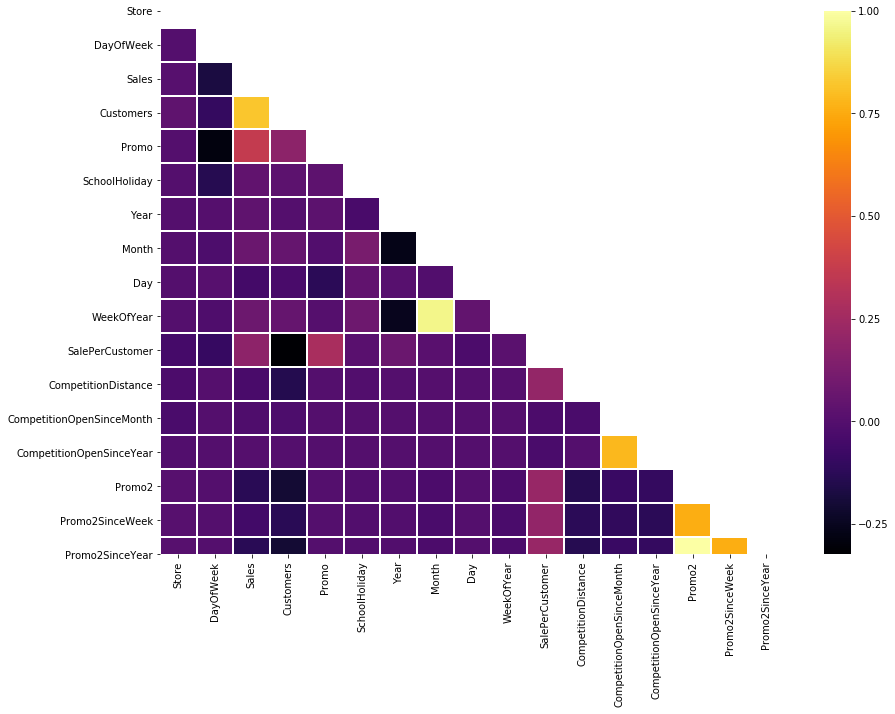

In [17]:
corr_all = tr_st.drop("Open", axis=1).corr()
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize = (14, 10))
sns.heatmap(corr_all, mask= mask,linewidths= 1, ax=ax, cmap="inferno")

In [18]:
print("""Strong Correlation analysis found in Customers and Sales, 
        while in case for promo it shows a weak correlation""")

Strong Correlation analysis found in Customers and Sales, 
        while in case for promo it shows a weak correlation


In [19]:
#getting sales of each store type
tr_st.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


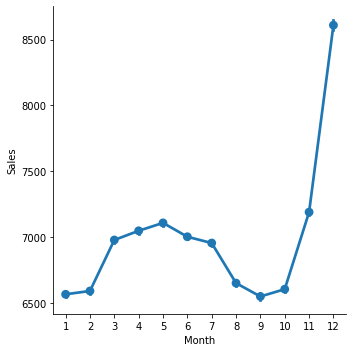

In [20]:
#plotting a graph of sales trends by year
sns.factorplot(data = tr_st, x = 'Month', y='Sales')

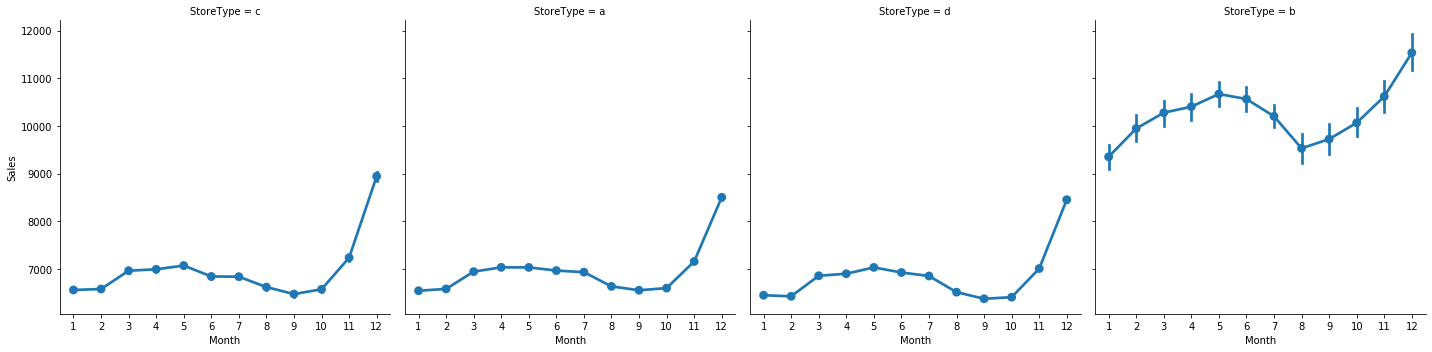

In [21]:
#plotting a graph for sales of each store type 
sns.factorplot(data = tr_st, x = 'Month', y='Sales', col='StoreType')

In [22]:
tr_st.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


In [23]:
print("""Thus according to the above analysis, Store type b tends towards more sales but on the 
      other hand we have less records for store b as compared to others""")

Thus according to the above analysis, Store type b tends towards more sales but on the 
      other hand we have less records for store b as compared to others


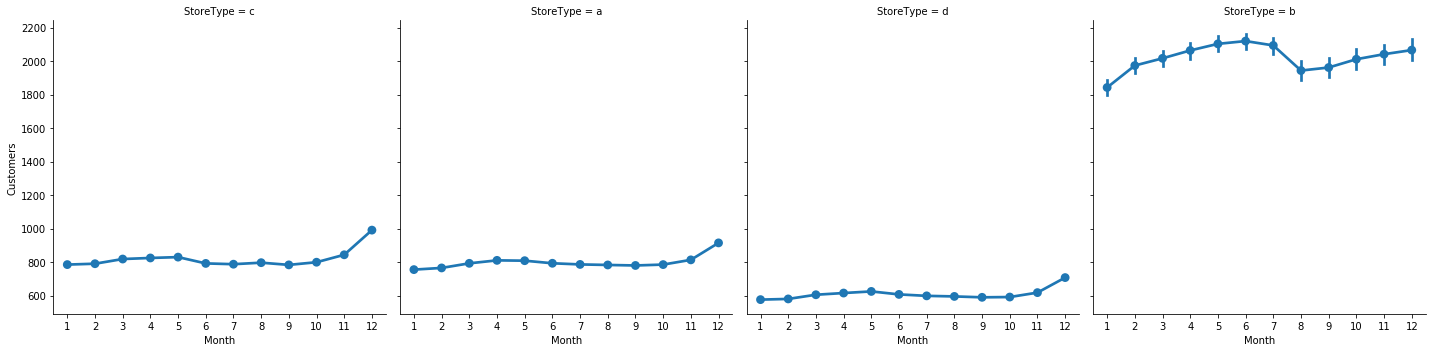

In [24]:
#customer trends
sns.factorplot(data = tr_st, x="Month", y="Customers", col="StoreType")

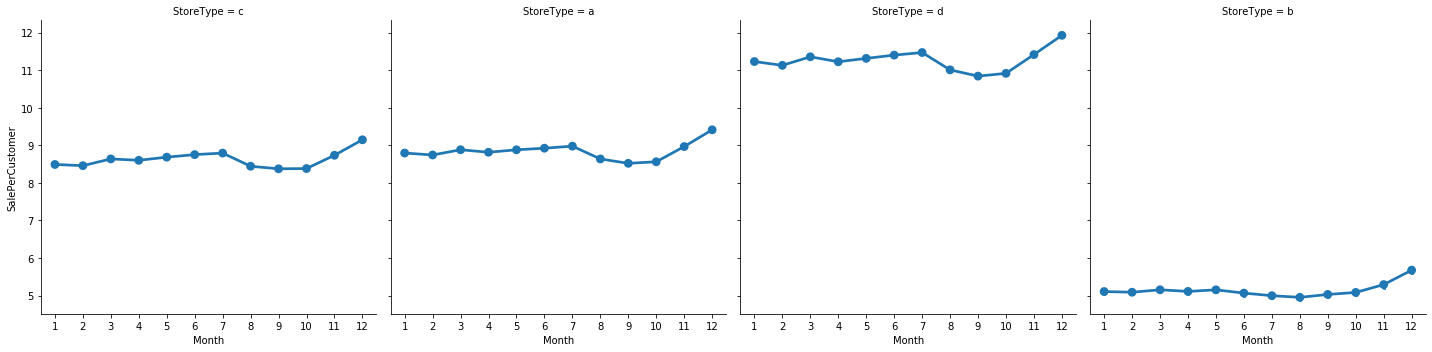

In [25]:
#salespercustomer graph
sns.factorplot(data = tr_st, x="Month", y="SalePerCustomer", col="StoreType")

In [26]:
print("""By the above analysis most of the Sales/Customer values goes for StoreType d, 
it means customers tends to buy expensive products froms store d""")

By the above analysis most of the Sales/Customer values goes for StoreType d, 
it means customers tends to buy expensive products froms store d


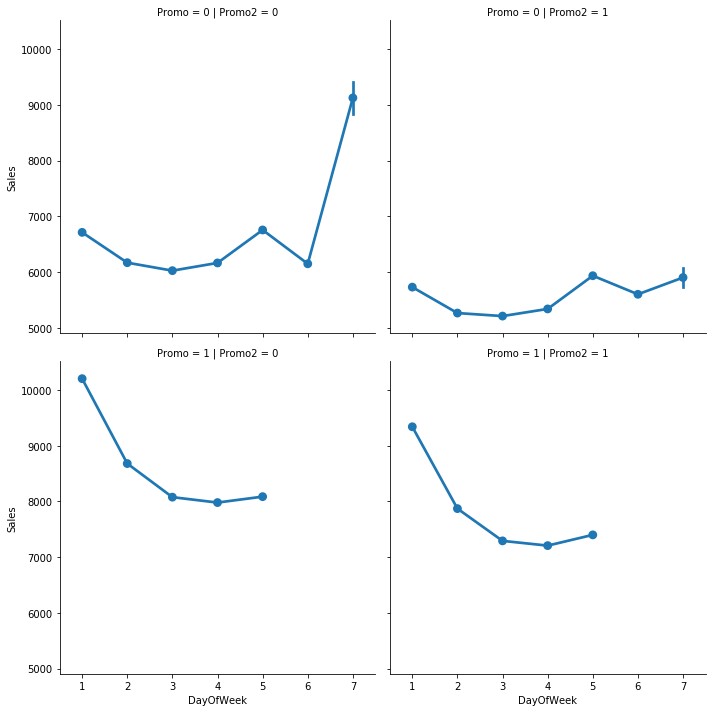

In [27]:
#analysis in case for promo, how sales depend when promo, promo2 is 1 or 0
sns.factorplot(data= tr_st, x='DayOfWeek', y='Sales', row="Promo", col="Promo2")

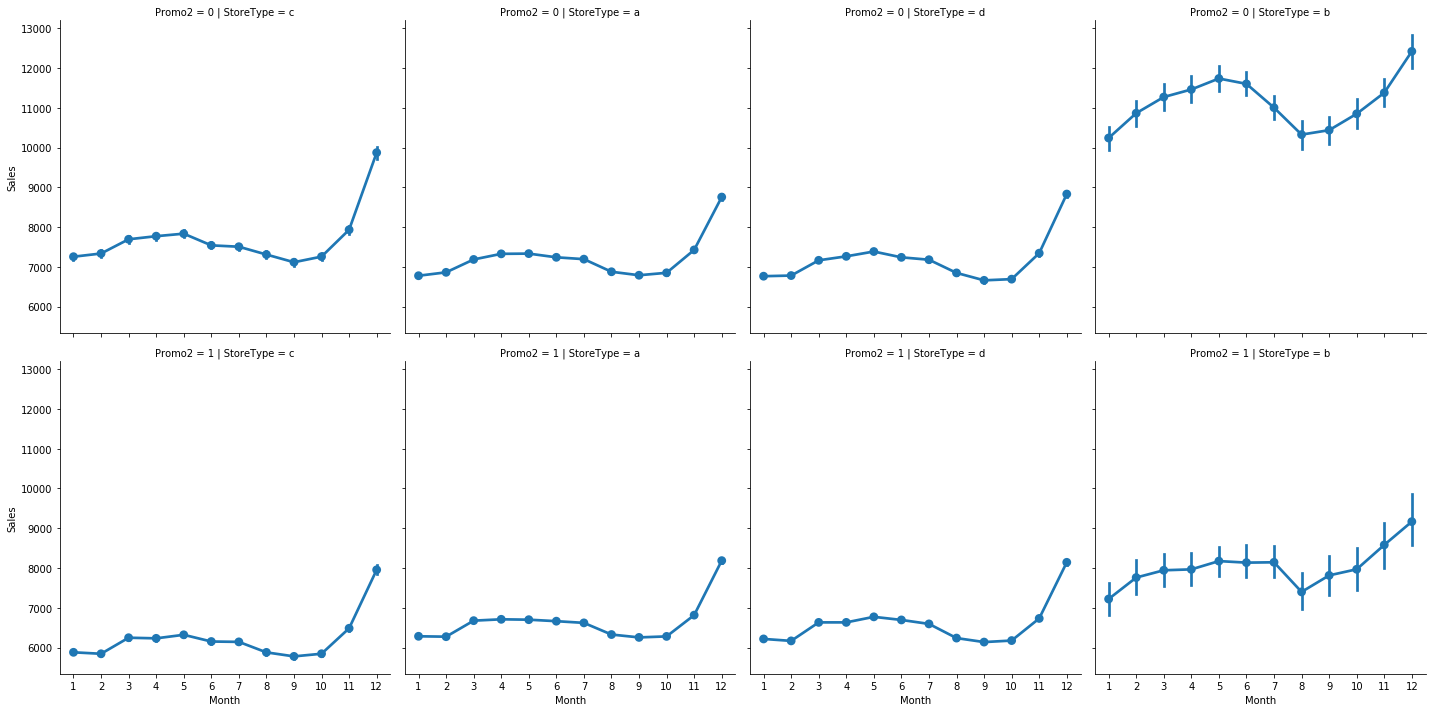

In [28]:
sns.factorplot(data= tr_st, x='Month', y='Sales', row="Promo2", col="StoreType")

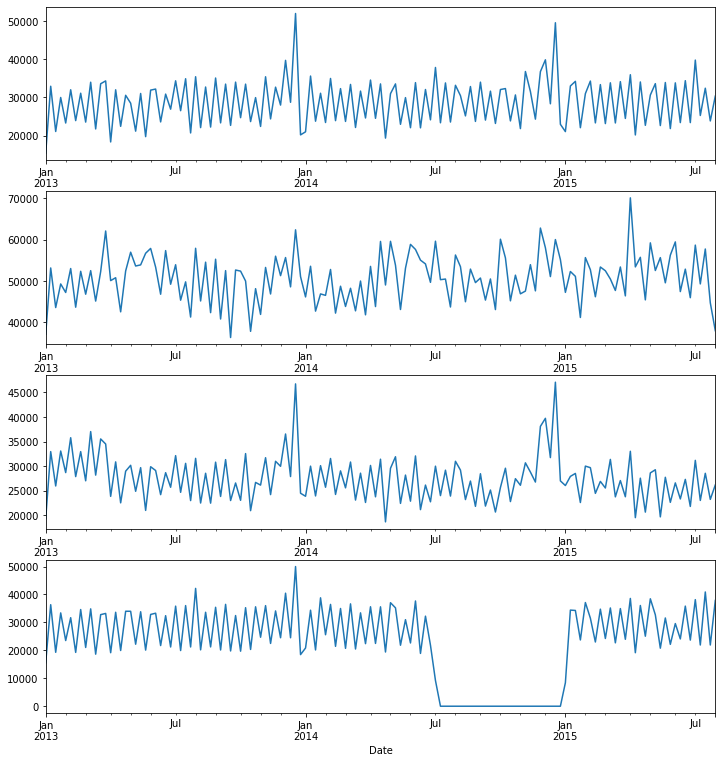

In [29]:
#Time Series Analysis
#analysing seasonality
data_tr['Sales'] = data_tr['Sales'] * 1.0
sales_a = data_tr[data_tr.Store == 2]['Sales']
sales_b = data_tr[data_tr.Store == 85]['Sales'].sort_index(ascending = True)
sales_c = data_tr[data_tr.Store == 1]['Sales']
sales_d = data_tr[data_tr.Store == 13]['Sales']
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
pd.plotting.register_matplotlib_converters()
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax= ax2)
sales_c.resample('W').sum().plot(ax= ax3)
sales_d.resample('W').sum().plot(ax= ax4)

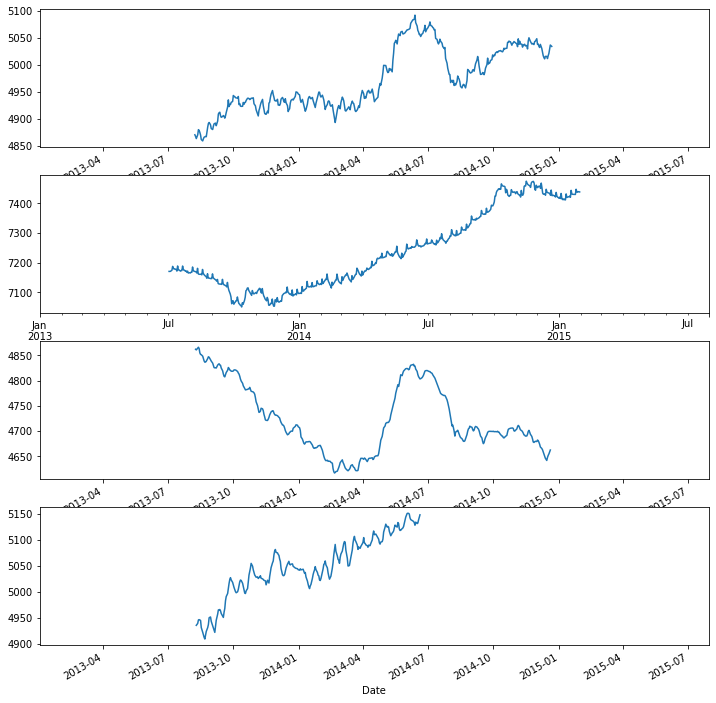

In [30]:
#analysis trends in our data
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize= (12, 13))
decompose_a = seasonal_decompose(sales_a, model = 'additive', freq=365)
decompose_a.trend.plot(ax= ax1)
decompose_b = seasonal_decompose(sales_b, model = 'additive', freq=365)
decompose_b.trend.plot(ax= ax2)
decompose_c = seasonal_decompose(sales_c, model = 'additive', freq=365)
decompose_c.trend.plot(ax= ax3)
decompose_d = seasonal_decompose(sales_d, model= 'additive', freq=365)
decompose_d.trend.plot(ax= ax4)

In [31]:
#implementing SARIMA
df = pd.read_csv('StoresData/input.csv')
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]
sales = df[df.Store == 1].loc[:, ['Date', 'Sales']]
sales = sales.sort_index(ascending = False)
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [32]:
sales.head()

,Date,Sales
1014980,2013-01-02,5530
1013865,2013-01-03,4327
1012750,2013-01-04,4486
1011635,2013-01-05,4997
1009405,2013-01-07,7176


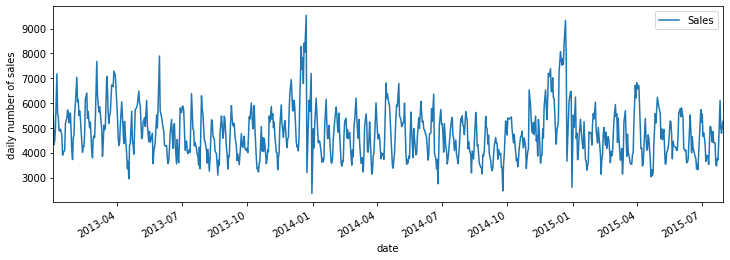

In [33]:
ax = sales.set_index('Date').plot(figsize = (12, 4))
ax.set_ylabel("daily number of sales")
ax.set_xlabel('date')
plt.show()

In [34]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [35]:
def sample(sales):
  return(sales.resample('MS').mean())

In [36]:
y_sale_a = sample(sales_a)
y_sale_b = sample(sales_b)
y_sale_c = sample(sales_c)
y_sale_d = sample(sales_d)

In [37]:
def model(i,sale):
  ex = data_tr.loc[data_tr['Store'] == i,['Customers','Promo']]
  y_sales = sale.resample('MS').mean()
  y_ex = ex.resample('MS').mean()
  exog = sm.add_constant(y_ex)
  exog.tail()
  return y_sales , exog

In [38]:
y_sale_model_a , exog_a = model(2,sales_a)
y_sale_model_b , exog_b = model(85,sales_b)
y_sale_model_c , exog_c = model(1,sales_c)
y_sale_model_d , exog_d = model(13,sales_d)

In [39]:
exog_a = exog_a.dropna()
exog_a.isna().sum()

exog_b = exog_b.dropna()
exog_b.isna().sum()

exog_c = exog_c.dropna()
exog_c.isna().sum()

exog_d = exog_d.dropna()
exog_d.isna().sum()

const        0
Customers    0
Promo        0
dtype: int64

In [40]:
def arima(y_sale,exog,or1,sord):
    mod = sm.tsa.statespace.SARIMAX(y_sale,
                                    exog,
                                    order=or1,
                                    seasonal_order=sord,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)



    results = mod.fit(disp=0)
    pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'), dynamic=False)
    pred_ci = pred.conf_int()

    ax = y_sale['2013':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

    ax.fill_between(pred_ci.index,
                      pred_ci.iloc[:, 1],
                      pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('sales')
    plt.legend()

    plt.show()


    y_forecasted = pred.predicted_mean
    y_truth = y_sale['2015-01-01':'2015-07-01']

    mse = ((y_forecasted - y_truth) ** 2).mean()
    rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
    rmspe =  np.sqrt(np.mean((y_forecasted/y_truth) ** 2))
    return results , mse,rmse,rmspe

C:\Users\dell\Miniconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



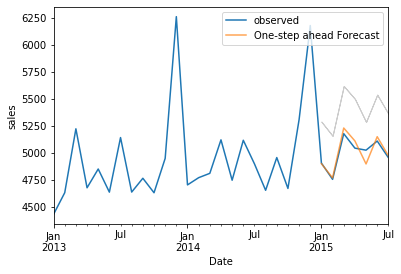

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(5, 1, 3)x(1, 0, 0, 12)   Log Likelihood                 -81.420
Date:                            Sun, 02 Feb 2020   AIC                            188.839
Time:                                    23:21:56   BIC                            196.183
Sample:                                01-01-2013   HQIC                           187.329
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019   2.76e+05  -6.95e-09      1.000   -5.41e+05    5.41e+05
Customers      6.3765     63.186   

In [41]:
or_a = (5,1,3)
sord_a=(1, 0, 0, 12)
result_a,mse_a,rmse_a,rmspe_a= arima(y_sale_model_a,exog_a,or_a,sord_a)
print(result_a.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_a, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_a, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_a, 2)))

C:\Users\dell\Miniconda3\envs\python3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



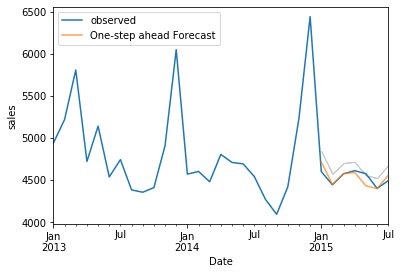

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   31
Model:             SARIMAX(2, 1, 2)x(1, 0, 0, 12)   Log Likelihood                 -90.298
Date:                            Sun, 02 Feb 2020   AIC                            198.596
Time:                                    23:21:56   BIC                            205.549
Sample:                                01-01-2013   HQIC                           198.952
                                     - 07-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0509    1.7e+04   6.19e-05      1.000   -3.33e+04    3.33e+04
Customers     11.3439      0.753   

In [42]:
or_c = (2,1,2)
sord_c=(1, 0, 0, 12)
result_c,mse_c,rmse_c,rmspe_c= arima(y_sale_model_c,exog_c,or_c,sord_c)
print(result_c.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_c, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_c, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_c, 2)))

In [43]:
#implementing prohpet model
df = pd.read_csv("StoresData/input.csv", low_memory=False)
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]
sales = df[df.Store == 1].loc[:, ["Date", "Sales"]]
sales = sales.sort_index(ascending=False)
sales['Date']= pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [44]:
sales = sales.rename(columns={'Date': 'ds', 'Sales':'y'})
sales.tail()

,ds,y
4460,2015-07-27,6102
3345,2015-07-28,5011
2230,2015-07-29,4782
1115,2015-07-30,5020
0,2015-07-31,5263


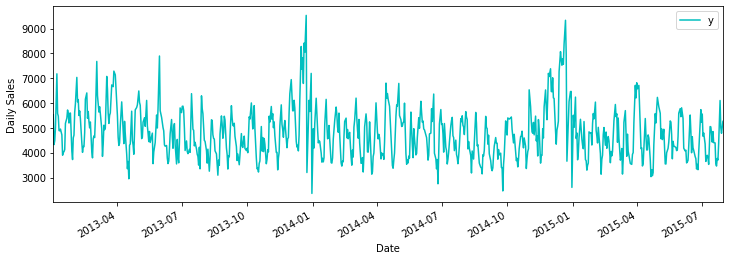

In [45]:
ax = sales.set_index('ds').plot(figsize = (12,4), color = 'c')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Sales')
plt.show()


In [46]:
#preparing holiday dataframe
stateholidays = df[(df.StateHoliday == 'a') | (df.StateHoliday == 'b') & (df.StateHoliday == 'c')].loc[:,'Date'].values
schoolholidays = df[(df.SchoolHoliday == 1)].loc[:,'Date'].values
state = pd.DataFrame({'holiday': 'state_holiday', 'ds': pd.to_datetime(stateholidays)})
school = pd.DataFrame({'holiday': 'school_holiday', 'ds': pd.to_datetime(schoolholidays)})
allholidays = pd.concat((state, school))
allholidays.tail()

,holiday,ds
163440,school_holiday,2013-01-01
163441,school_holiday,2013-01-01
163442,school_holiday,2013-01-01
163443,school_holiday,2013-01-01
163444,school_holiday,2013-01-01


In [47]:
fbmodel = Prophet(interval_width = 0.90, holidays=allholidays)
fbmodel.fit(sales)
future_dates = fbmodel.make_future_dataframe(periods = 6*7)
print('Weekly Forecast')
future_dates.tail(7)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Weekly Forecast


,ds
816,2015-09-05
817,2015-09-06
818,2015-09-07
819,2015-09-08
820,2015-09-09
821,2015-09-10
822,2015-09-11


In [48]:
forecastsales = fbmodel.predict(future_dates)
forecastsales[['ds','yhat','yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
816,2015-09-05,4092.196373,2844.024618,5415.302828
817,2015-09-06,4086.982771,2818.431567,5487.394273
818,2015-09-07,4161.672877,2799.925730,5551.589110
819,2015-09-08,3664.111439,2233.101941,5090.210120
820,2015-09-09,3550.936324,2238.774079,4855.408830
821,2015-09-10,3462.430053,2125.274903,4755.217386
822,2015-09-11,3717.080395,2334.084638,5020.919480
